# DE27IM Class Tests

When written in binary, the 27 bit relationship contains 3 9-bit
parts corresponding to DE-9IM relationships. The left-most 9 bits
are the relationship between the second structure's contour and the
first structure's convex hull polygon. The middle 9 bits are the
relationship between the second structure's contour and the first
structure's exterior polygon (i.e. with any holes filled). The
right-most 9 bits are the relationship between the second
structure's contour and the first structure's contour.

Args:
    slice_structures (pd.DataFrame): A table of structures, where
        the values are the contours with type StructureSlice. The
        column index contains the roi numbers for the structures.
        The row index contains the slice index distances.

Returns:
    DE9IM_Type: An integer corresponding to a 27 bit binary value
        reflecting the combined DE-9IM relationship between contour2 and
        contour1's convex hull, exterior and polygon.

## Setup

### Imports

In [2]:
# Shared Packages
import pandas as pd

# Local functions and classes
from types_and_classes import *
from utilities import *
from debug_tools import *
from structure_slice import *
from relations import *

### Global Settings

In [3]:
PRECISION = 2

In [4]:
%matplotlib inline

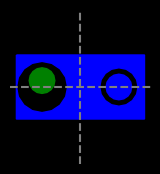

|001|	|111|	|111|
|001|	|001|	|001|
|111|	|001|	|001|

Relationship: Surrounds


In [5]:
def surrounds_example3():
    box10x5 = shapely.Polygon(box_points(10,5))
    circle4_left = shapely.Polygon(circle_points(2, offset_x=-3))
    circle3_right = shapely.Polygon(circle_points(1.5, offset_x=3))
    circle2_left = shapely.Polygon(circle_points(1, offset_x=-3, offset_y=0.5))
    circle2_right = shapely.Polygon(circle_points(1, offset_x=3))
    a = StructureSlice([box10x5, circle4_left, circle3_right, circle2_right])
    b = StructureSlice([circle2_left])
    return a, b

a, b = surrounds_example3()
ax = plot_ab(a.contour, b.contour)

r = DE27IM(a,b)
print(str(r))
print(r.identify_relation())

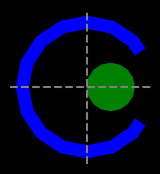

|001|	|001|	|111|
|001|	|001|	|001|
|111|	|111|	|001|

Relationship: Unknown


In [6]:
def shelters_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle4_offset = shapely.Polygon(circle_points(2, offset_x=3.5))
    shell = shapely.difference(circle6, circle5)
    cove = shapely.difference(shell, circle4_offset)
    circle2 = shapely.Polygon(circle_points(1, offset_x=1))

    a = StructureSlice([cove])
    b = StructureSlice([circle2])
    return a, b

a, b = shelters_example()
ax = plot_ab(a.contour, b.contour)

r = DE27IM(a,b)
print(str(r))
print(r.identify_relation())

In [7]:
poly_a = shapely.Polygon(circle_points(2))
poly_b = shapely.Polygon(circle_points(2))
relation = DE9IM(poly_a, poly_a)
print(relation)
relation

|100|
|010|
|001|


<DE9IM>: 2FFF1FFF2

In [8]:
relation_str = '111000000111000000111000000'
relation_str[9:]

'111000000111000000'

In [9]:
box6 = shapely.MultiPolygon([shapely.Polygon(box_points(6))])
box4 = shapely.MultiPolygon([shapely.Polygon(box_points(4))])
relation = DE9IM(box4, box6)
boundary_relation = relation.boundary_adjustment('b')
print(boundary_relation)
boundary_relation

|010|
|010|
|011|


<DE9IM>: F2FF1FF22

In [10]:
relation_str = '111000000111000000111000000'
de27im = DE27IM(relation_str=relation_str)

In [11]:
DE27IM.test_binaries[7].relation_type


<RelationshipType.EQUALS: 9>

In [12]:
v = DE27IM.test_binaries[7].mask - DE27IM.test_binaries[7].value
v = DE27IM.test_binaries[7].value
de27im = DE27IM(relation_int=v)
de27im.identify_relation()

<RelationshipType.EQUALS: 9>

## Adjusting Boundary Slice Relations

For the beginning and ending slices of a structure the entire contour must
be treated as a boundary.  The structure does not have an interior on these
slices. In this case the “*Interior*” relations become “*Boundary*” relations.

The “*Interior*” bits of the DE-9IM relationship metric are combined with the 
“*Boundary*” bits using "OR" logic.  This will keep the “*Boundary*” bits as 
part of the boundary.



The `boundary_adjustment` method of the `DE9IM` class converts *interior* relations to *boundary* relations.

The `boundary_type` argument of the method takes one of two options:
<link rel="stylesheet" href="relations.css">
<table>
<tr><td><B><I>'a'</B></I></td>
<td>The <span class="a">a</span> polygon is from a boundary slice</td>
<td><img src="Images/Boundaries/a interior to boundary.png" /></td>
</tr><tr>
<td><B><I>'b'</B></I></td>
<td>The <span class="b">b</span> polygon is from a boundary slice</td>
<td><img src="Images/Boundaries/b interior to boundary.png" /></td>
</tr><tr>
</table>


![surrounds with ring](<Images/Relationships/surrounds with ring.png>)

In [13]:
def surrounds_example2():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle4 = shapely.Polygon(circle_points(2))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle5, circle2])
    b = StructureSlice([circle4, circle3])
    return a, b

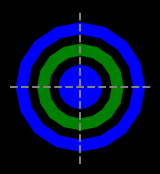

('FF2FF1212', '212FF1FF2', '212FF1FF2')


In [16]:
a, b = surrounds_example2()
plot_ab(a.contour, b.contour)
contour = a.contour.relate(b.contour)
external = a.exterior.relate(b.contour)
convex_hull = a.hull.relate(b.contour)
relation_group = (contour, external, convex_hull)
print(relation_group)

**Original**<br>
|Contour|Exterior|Hull|
|-----|-----|-----|
| FF2 | 212 | 212 |
| FF1 | FF1 | FF1 |
| 212 | FF2 | FF2 |

`('FF2FF1212','212FF1FF2','212FF1FF2')`<br>


**Boundary A Adjustment**<br>
<img src="Images/Boundaries/a interior to boundary.png" style="height:150px;"/><br>
|Contour|Exterior|Hull|
|-----|-----|-----|
| FFF | FFF | FFF |
| FF2 | 212 | 212 |
| 212 | FF2 | FF2 |


`('FFFFF2212','FFF212FF2','FFF212FF2')`<br>
(<DE9IM>: FFFFF2212, <DE9IM>: FFF212FF2, <DE9IM>: FFF212FF2)

**Boundary B Adjustment**<br>
<img src="Images/Boundaries/b interior to boundary.png" style="height:150px;"/><br>
|Contour|Exterior|Hull|
|-----|-----|-----|
| FF2 | F22 | F22 |
| FF1 | FF1 | FF1 |
| F22 | FF2 | FF2 |

`('FF2FF1F22','F22FF1FF2','F22FF1FF2')`<br>


In [22]:
def clean_relation(relation_str:str)->str:
    cleaned_relation_str = relation_str.replace('F','0').replace('2','1')
    return cleaned_relation_str

initial_relation_group = (DE9IM(relation_str='FF2FF1212'),
                          DE9IM(relation_str='212FF1FF2'),
                          DE9IM(relation_str='212FF1FF2'))
print(f'Initial Relation:\t\t{initial_relation_group}')

boundary_a_adjustment = (DE9IM(relation_str='FFFFF2212'),
                         DE9IM(relation_str='FFF212FF2'),
                         DE9IM(relation_str='FFF212FF2'))

print(f'After Boundary A Adjustment:\t{boundary_a_adjustment}')

boundary_b_adjustment = (DE9IM(relation_str='FF2FF1F22'),
                         DE9IM(relation_str='F22FF1FF2'),
                         DE9IM(relation_str='F22FF1FF2'))
print(f'After Boundary B Adjustment:\t{boundary_b_adjustment}')


Initial Relation:		(<DE9IM>: FF2FF1212, <DE9IM>: 212FF1FF2, <DE9IM>: 212FF1FF2)
After Boundary A Adjustment:	(<DE9IM>: FFFFF2F22, <DE9IM>: FFFF22FF2, <DE9IM>: FFFF22FF2)
After Boundary B Adjustment:	(<DE9IM>: FF2FF1F22, <DE9IM>: F22FF1FF2, <DE9IM>: F22FF1FF2)


In [28]:
de27im = DE27IM(relation_int=0)
adjusted_de27im = de27im.apply_adjustments(initial_relation_group, ['boundary_a'])
boundary_a_adjustment = (DE9IM(relation_str='FFFFF2212'),
                         DE9IM(relation_str='FFF212FF2'),
                         DE9IM(relation_str='FFF212FF2'))
print(adjusted_de27im)
print(boundary_a_adjustment)

(<DE9IM>: FFFFF2212, <DE9IM>: FFF212FF2, <DE9IM>: FFF212FF2)
(<DE9IM>: FFFFF2212, <DE9IM>: FFF212FF2, <DE9IM>: FFF212FF2)


In [ ]:
<DE9IM>: FFFFF2212 !=
<DE9IM>: FFFFF2212
E